### This is an interactive notebook for the measles model, and running impact and cost modeling on a measle vaccine intervention scenario. 
* The output for this intervention example is in geojson
* The impact function shows the perturbed values for the number of measles cases post intervention.
* The cost is the total cost of the intervention in USD.


In [1]:
import os
os.chdir("/usr/src/app")

In [2]:
import glob
import re
import json
import datetime
import pandas as pd
import geopandas as gpd
import pickle

import boto3
import luigi
from luigi.format import Nop
from luigi.parameter import DateIntervalParameter
from luigi.date_interval import Custom as CustomDateInterval
from kiluigi import FinalTarget
from ipywidgets import widgets, interactive,Label, Layout,Text, HTML
from ipyleaflet import Map, GeoData, basemaps, LayersControl, WidgetControl, GeoJSON 
import geopandas
from interventions.intervention_model import Intervention_provide

import matplotlib.pyplot as plt
from mapclassify import Quantiles, UserDefined,NaturalBreaks
from mpl_toolkits.axes_grid1 import make_axes_locatable

from models.measles_model.tasks import PredictionGeojson, mixedlinear_model


### Step 1. Get the indicator dataset. This can be provided manually by the user or generated from running a Luigi task
* The parameters specify here only affect the indicator dataset itself (not intervention).

In [3]:
# use interactive, not interact to easily access the input value!

slider_style = Layout(width='50%', height='30px')
descript_style = {'description_width': 'initial'}
year = widgets.IntSlider(description='Year:', orientation='horizontal',step=1, 
                         min=2010, max=2020, 
                         value=2019)
month1 = widgets.IntSlider(description='Starting Month: ', orientation='horizontal',step=1, min=1, max=12, 
                           value=3,style=descript_style, layout=slider_style)
month2 = widgets.IntSlider(description='Ending Month:', orientation='horizontal',step=1, min=1, max=12, 
                           value=8,style=descript_style, layout=slider_style)

def input_val(x):
    return str(x)

yr_wd = widgets.interactive(input_val, x=year)
display(yr_wd)

month1_wd = widgets.interactive(input_val, x=month1)
display(month1_wd)

month2_wd = widgets.interactive(input_val, x=month2)
display(month2_wd)

country_wd = widgets.Dropdown(
    options=['Ethiopia', 'South Sudan'],
    description='Country:',
    disabled=False,
)
display(country_wd)



interactive(children=(IntSlider(value=2019, description='Year:', max=2020, min=2010), Output()), _dom_classes=…

interactive(children=(IntSlider(value=3, description='Starting Month: ', layout=Layout(height='30px', width='5…

interactive(children=(IntSlider(value=8, description='Ending Month:', layout=Layout(height='30px', width='50%'…

Dropdown(description='Country:', options=('Ethiopia', 'South Sudan'), value='Ethiopia')

In [4]:
timepoint = yr_wd.result+'-'+month1_wd.result.zfill(2)+'-01-'+yr_wd.result+'-'+month2_wd.result.zfill(2)+'-01'

#### Run the model based on User defined input in a luigi task.
* for this luigi task, `country_level` refers to the country of interest.
* `geography` is the geographical coverage for the output.
* `rainfall_scenario_geography` is an arbitrary AOI for rainfall scenario (must be within `geography`.
* `rainfall_scenario_time` is an arbitrary time interval for the rainfall scenario (must be within `time`)the model based on User defined input

In [5]:
# for Ethiopia, define geography
eth_geo_file = {"coordinates": [[[36.357226629663501, 14.272502682267801],[37.2970544510355, 14.6772882598167],[37.719862777828297, 15.0348782791802],[38.406926308866502, 14.8050668691039],[40.0981596160373, 14.4726873923002],[41.630839800661001, 13.4982974690825],[42.529307495095502, 12.365084475553299],[41.921520525330997, 11.1750924233907],[42.925690301463703, 11.1750924233907],[43.004966862737298, 10.578226842108799],[44.141264240992797, 9.224600687836],[47.033937477102299, 8.239013541804599],[48.343304299598302, 8.21360385046173],[45.151070168399599, 4.73902070129281],[43.621706074706402, 4.59611835261279],[42.379097748580598, 3.85735258666634],[41.255970992274698, 3.73813341072871],[40.730252085067598, 4.02423122213936],[39.631021642725599, 3.30881385146286],[38.8185469679511, 3.30881385146286],[38.029968607140503, 3.42808897514322],[36.906841850834503, 4.19107567031119],[35.9031966643484, 4.28639946386431],[35.568648268853003, 5.04853993824516],[35.042929361645903, 5.23894050051229],[34.732277280114502, 6.38005314679845],[32.772779535070001, 7.87384558608177],[33.035638988673597, 8.583349846796411],[33.872009977412098, 8.65422922148511],[34.134869431015602, 10.656535086660901],[36.357226629663501, 14.272502682267801]]], "type": "Polygon"}

In [6]:
mixedlm=mixedlinear_model()

MeaslesInference = PredictionGeojson(
    time=DateIntervalParameter().parse(timepoint),
    country_level=country_wd.value,
    geography=eth_geo_file,     
)

In [7]:
luigi.build([mixedlm, MeaslesInference], local_scheduler=True, no_lock=True)

[2021-01-05 22:41:59,406] INFO [luigi:75] logging configured via *.conf file
[2021-01-05 22:41:59,418] INFO [luigi-interface:103] ExpiringLocalTarget 'output/intermediate/models/measles_model/tasks/mixedlinear_model/mixedlinear_model__99914b932b.pickle' expired 3019964s ago at 2020-12-01 23:49:14.831306+00:00 and has been removed
[2021-01-05 22:41:59,421] INFO [luigi-interface:103] ExpiringLocalTarget 'output/intermediate/models/measles_model/tasks/lagDF_eth/lagDF_eth__99914b932b.pickle' expired 3019964s ago at 2020-12-01 23:49:14.707957+00:00 and has been removed
[2021-01-05 22:41:59,422] INFO [luigi-interface:587] Informed scheduler that task   models.measles_model.tasks.mixedlinear_model__99914b932b   has status   PENDING
[2021-01-05 22:41:59,425] INFO [luigi-interface:103] ExpiringLocalTarget 'output/intermediate/models/measles_model/tasks/MergeDF_eth/MergeDF_eth__99914b932b.pickle' expired 3019965s ago at 2020-12-01 23:49:14.004945+00:00 and has been removed
[2021-01-05 22:41:59,4

/opt/conda/lib/python3.8/site-packages/pandas/core/generic.py:6745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


[2021-01-05 22:43:19,115] INFO [luigi-interface:208] [pid 305] Worker Worker(salt=841682483, workers=1, host=01effb7f57a8, username=jovyan, pid=305) done      models.measles_model.tasks.lagDF_eth()
[2021-01-05 22:43:19,117] INFO [luigi-interface:587] Informed scheduler that task   models.measles_model.tasks.lagDF_eth__99914b932b   has status   DONE
[2021-01-05 22:43:19,118] INFO [luigi-interface:157] [pid 305] Worker Worker(salt=841682483, workers=1, host=01effb7f57a8, username=jovyan, pid=305) running   models.measles_model.tasks.mixedlinear_model()
rmse:  85.10814508937594
r2 score:  0.9918310963450861
[2021-01-05 22:43:19,225] INFO [luigi-interface:208] [pid 305] Worker Worker(salt=841682483, workers=1, host=01effb7f57a8, username=jovyan, pid=305) done      models.measles_model.tasks.mixedlinear_model()
[2021-01-05 22:43:19,227] INFO [luigi-interface:587] Informed scheduler that task   models.measles_model.tasks.mixedlinear_model__99914b932b   has status   DONE
[2021-01-05 22:43:19,

/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


True

### Step 2. Run intervention impact on the output of the luigi task. Define the following parameters to instantiate an intervention scenario.

For geojson data, it needs to have specified feature names pointing to the indicator data corresponding to `indicator_col` and timestamp corresponding to `period_col` in `Intervention_model()`.

For the `provide_type` argument, the options are `Free food distribution`,`Supplementary feeding`, `School feeding` and `vaccine`.

The intervention model requires 2 sets of input parameters.
* The Greek alphabets defined the intrinsic property of the intervention (the default values are set according to `provide_type`.
  *  alpha1: placebo effect (e.g 0.1 for food, 0 for vaccine) 
  *  beta1: impact for first round (between 0-1)
  *  beta2: slope impact per increase in quantity of treatments(between 0-1)
  *  beta3: slope impact per increase in an unit of treatment (not to exceed 1)
  *  delta1: decay of the treatment efficiency over time (between 0-1)
  *  gamma2: exponent decay per increase in quantity of treatments as time goes by (between 0-1)
  *  gamma3: exponent decay of the increase per unit dose in time. (between 0-1)
* The other parameters are related to the scale of the intervention
  * q1: number of recipients per round of intervention
  * q2: number of intervention events (integer). It needs to correspond to reporting_dur
  * q3: quantity of treatment/transaction for one round of intervention
  * q3_1 to q3_4: the suffix refer to the different items in one unit of treament for one round of intervention (this is for estimating the total cost)
  * q3_norm: normalized dose/treatment delivery efficiency
  * interv_window: frequency of the intervention (e.g. every 7 days)
  * reporting_dur: total duration of the intervention period (approximately q2 * interv_window)

In [8]:
# read the output into a GeoDataFrame

measles_target = MeaslesInference.output().path
print(measles_target)

s3://darpa-output-dev/final_targets/measles_cf059127cd.geojson


In [5]:
cost_fname='https://darpa-output-dev.s3.amazonaws.com/final_targets/cost1_reg_output_4c717b2e0d.pickle'

measles_target='s3://darpa-output-dev/final_targets/measles_cf059127cd.geojson'

#### For vaccine intervention, it uses the following as default inputs to the `Intervention_model()`. This is a scenario where 2 doses of vaccine are given every 30 days
* alpha1=0.0, beta1=0.92, beta2=0.07, beta3=0, delta1=0.0
* q3=2, q3_norm=1,q3_1=1,q3_2=None, q3_3=None, q3_4=None,
* interv_window=30

In [6]:
measles_intervention=Intervention_provide(indicator_col='measles_number',
                                        provide_type='vaccine',
                                        admin_level='admin1',
                                        period_col='timestamp',
                                        )

impact_effect, impact_cost=measles_intervention.impact_calculation(source_fname=measles_target,
                                         q1=50,
                                         q2=4, q3=2, q3_norm=1,
                                         q3_1=1,q3_2=None, q3_3=None, q3_4=None,
                                         interv_window=30,
                                         reporting_dur=30*4)


/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.8/site-packages/xarray/core/computation.py:604: RuntimeWarning: invalid value encountered in true_divide
  result_data = func(*input_data)


In [7]:
intervention_output=impact_effect
print(f'cost of this intervention: ${impact_cost:.2f} USD')

cost of this intervention: $692.00 USD


In [8]:
post_intervention1=intervention_output.to_dataframe().reset_index()
post_intervention1=gpd.GeoDataFrame(post_intervention1)
post_intervention1.dropna(inplace=True)
post_intervention1.head()

admin1       date  baseline  intervention  \
0  Addis Ababa 2019-04-01      91.0            89   
1  Addis Ababa 2019-04-02      91.0            89   
2  Addis Ababa 2019-04-03      91.0            89   
3  Addis Ababa 2019-04-04      91.0            89   
4  Addis Ababa 2019-04-05      91.0            89   

                                            geometry  
0  POLYGON ((38.85556 8.93829, 38.86083 8.93218, ...  
1  POLYGON ((38.85556 8.93829, 38.86083 8.93218, ...  
2  POLYGON ((38.85556 8.93829, 38.86083 8.93218, ...  
3  POLYGON ((38.85556 8.93829, 38.86083 8.93218, ...  
4  POLYGON ((38.85556 8.93829, 38.86083 8.93218, ...

### Visualize intervention in xarray format

In [9]:
post_intervention1['diff']=post_intervention1['baseline']-post_intervention1['intervention']

### Visualize intervention using geopanda format (before and after)
 - natural breaks plot bins the data such there is less variation in each class or shading.
 - first plot is the intervention time point when vaccine is distributed
 - second plot is the post intervention effect in the following month
 
###### with help from https://github.com/geopandas/geopandas/issues/1019

In [10]:
def intervention_plot(df, period_col, time,feat, 
                      title1='with no intervetion', title2='post intervention'):
    """
    month: name like April, December
    feat: column or variable of interest in a list (e.g. ['measles_number', 'post_interv_number'])
    """
    num_plots=len(time)
    bins = NaturalBreaks(df[feat[0]], 5).bins
    if num_plots<3:
        fig, axe = plt.subplots(1, num_plots, figsize=(15,15))
    else:
        cols=int(num_plots/2)
        fig, axe = plt.subplots(2, cols, figsize=(15,15))
        
    for i in range(len(time)):
        select_df=df.loc[df[period_col]==time[i]]
        divider = make_axes_locatable(axe.flat[i])
        cax = divider.append_axes("right", size="5%", pad=0.1)
        ax=select_df.assign(cl=UserDefined(select_df[feat[0]].dropna(),list(bins)).yb).plot(column='cl', ax=axe.flat[i], cmap='OrRd', legend=True,cax=cax)
        #ax=select_df.plot(column='diff', ax=axe.flat[i], cmap='OrRd', legend=True,cax=cax)
        ax.set_title(f'Intervention Difference {time[i]}')
    

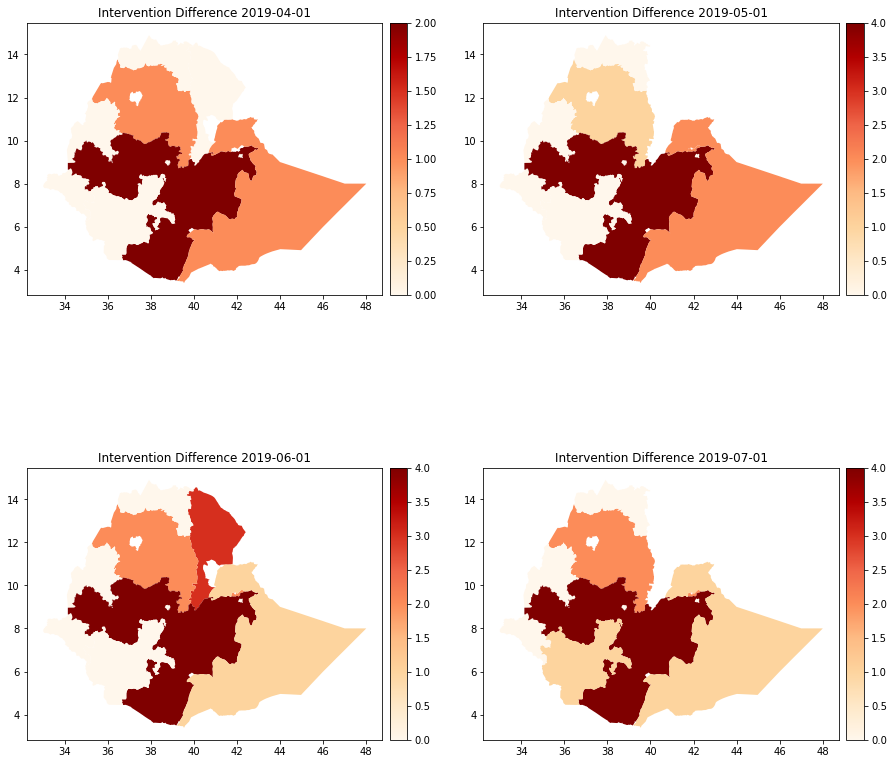

In [11]:
intervention_plot(post_intervention1, 'date',
                  ['2019-04-01','2019-05-01', '2019-06-01', '2019-07-01'],
                  ['diff'],)

In [17]:
area = widgets.Dropdown(
    options=['All'] + list(post_intervention1['admin1'].unique()),
    value='All',
    description='Admin:',
)
def plotit(area):
    
    if area != 'All':
        region_df=post_intervention1.loc[post_intervention1['admin1']==area]
        region_df.set_index(['date'], inplace=True)
       
        region_df['baseline'].plot( marker='.',alpha=0.4,color='grey', legend=True)
        region_df['intervention'].plot(marker='.',alpha=0.8,color='orange',legend=True)
    else:
        print('no data available, please select from drop down')

In [18]:
interactive(plotit, area=area)

interactive(children=(Dropdown(description='Admin:', options=('All', 'Addis Ababa', 'Afar', 'Amhara', 'Benisha…